In [1]:
import numpy as np
import seaborn as sn
import scipy as sp
import matplotlib.pyplot as plt
from math import factorial
from scipy.special import eval_genlaguerre

In [2]:
# Jonah's conventions for the unit cell and stuff
q1 = -np.array([0.0,-1.0],dtype = complex)  # lattice vectors in the Q lattice
q2 = -np.array([np.sqrt(3)/2,0.5],dtype = complex)
q3 = -np.array([-np.sqrt(3)/2,0.5],dtype = complex)

b1 = q2 - q1
b2 = q3 - q1

# Lattice vectors
a1 = (2./3)*np.array([-np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice
a2 = (2./3)*np.array([np.sqrt(3)/2,-0.5],dtype = complex)  # lattice vectors in the Q lattice

# special points in the MBZ
kpt = -q3 # The K point
gpt = np.array([0.0,0.0], dtype = complex) # The Gamma point
mpt = -q3 - 0.5*q1 # The M point
mmpt = -mpt
kppt = -kpt

# 3 parameters  
w1 = 1./np.sqrt(3)*0.1
w0 = 8./(10.*np.sqrt(3))*0.1
vFkth = 110.0*np.sqrt(3)

In [3]:
def distance(a,b): # finds the distance between two complex vectors
    x0, y0 = np.real(a) # because they were complex, cast to real and then unpack to get x, y
    x1, y1 = np.real(b)
    return(np.sqrt((x0-x1)**2 + (y0 - y1)**2))

In [4]:
formFactors1 = np.load('TBG_Form_Factors_G1.npy')
formFactors2 = np.load('TBG_Form_Factors_G2.npy')

def calculateMatrixElement1(k,m,n):
    G1 = 1.
    G2 = 0. 
    k1 = 2*np.pi*np.dot(a1,k)
    k2 = 2*np.pi*np.dot(a2,k)
    return(np.exp(1.0j*(k1*G2-k2*G1)) * formFactors1[m][n])

def calculateMatrixElement2(k,m,n):
    G1 = 0.
    G2 = 1. 
    k1 = 2*np.pi*np.dot(a1,k)
    k2 = 2*np.pi*np.dot(a2,k)
    return(np.exp(1.0j*(k1*G2-k2*G1)) * formFactors2[m][n])

In [5]:
# generate path in MBZ to plot
numpoints = 50 # path divided into pieces.  There are 3*numpoints, from K to Gamma to M to K
g_to_k = [gpt * (1.0 - (t+0.0)/numpoints) + kpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from K to Gamma
k_to_m = [kpt * (1.0 - (t+0.0)/numpoints) + mpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from Gamma to M
m_to_g = [mpt * (1.0 - (t+0.0)/numpoints) + gpt * ((t+0.0)/numpoints) for t in range(numpoints)] # from M to K
g_to_mm = [gpt * (1.0 - (t+0.0)/numpoints) + mmpt * ((t+0.0)/numpoints) for t in range(numpoints)]
mm_to_kp = [mmpt * (1.0 - (t+0.0)/numpoints) + kppt * ((t+0.0)/numpoints) for t in range(numpoints)]

list_of_points = g_to_k+k_to_m+m_to_g+g_to_mm+mm_to_kp # + means append here, so the list is 3*numpoints long
array_of_points = np.array(list_of_points) # to numpy array

# some intervals between points are longer than others.  Fix by normalizing by length
len_k = [0.0] # this is the x-axis of the band structure plot.  starting at 0,
prev_k = 0.0
for i in range(len(list_of_points) - 1):
    prev_k += distance(array_of_points[i+1],array_of_points[i]) # add distances cumulatively
    len_k.append(prev_k)

In [6]:
# First calculate the t-matrices, which do not change for different k-points, and kinetic terms

num_landau = 80
energy = np.sqrt((3*np.sqrt(3))/(2*np.pi))
kinetic_1 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
kinetic_2 = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t1_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t2_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
t3_matrix = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)

# First we add the kinetic terms
for m in range(-num_landau,num_landau+1): 
    kinetic_1[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)
    kinetic_2[m][m] = energy * np.sqrt(abs(m)) *np.sign(m)

# The second kinetic term is more complicated    
for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):
        if (abs(m)-1 == abs(n)):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = 1.0j*np.sign(m)*coeff
        elif (abs(m) == abs(n)-1):
            coeff = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            kinetic_2[m][n] = -1.0j*np.sign(n)*coeff

# now the T-matrices, but the k-dependence is factored out
for m in range(-num_landau,num_landau+1):
    for n in range(-num_landau,num_landau+1):            
        coe = 1.0/((np.sqrt(2))**(np.sign(abs(n)) + np.sign(abs(m))))
            
        t2_matrix[m][n] += coe*w0*formFactors1[abs(m),abs(n)]
        t3_matrix[m][n] += coe*w0*formFactors2[abs(m),abs(n)]
            
        if abs(n) > 0 and abs(m) > 0:
            t2_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors1[abs(m)-1,abs(n)-1]
            t3_matrix[m][n] += np.sign(m*n)*coe*w0*formFactors2[abs(m)-1,abs(n)-1]

        if abs(n) > 0:
            t2_matrix[m][n] += np.sign(n)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors1[abs(m),abs(n)-1]
            t3_matrix[m][n] += np.sign(n)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors2[abs(m),abs(n)-1]

        if abs(m) > 0:
            t2_matrix[m][n] += np.sign(m)*coe*w1*np.exp(2.0j*np.pi/3)*formFactors1[abs(m)-1,abs(n)]
            t3_matrix[m][n] += np.sign(m)*coe*w1*np.exp(-2.0j*np.pi/3)*formFactors2[abs(m)-1,abs(n)]

        if abs(m) == abs(n):
            t1_matrix[m][n] += w0*coe
            if abs(m) != 0:
                t1_matrix[m][n] += w0*coe*np.sign(m*n)
                    
        if abs(m)-1 == abs(n) and abs(m) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(m)
                
        if abs(n)-1 == abs(m) and abs(n) != 0:
            t1_matrix[m][n] += w1*coe*np.sign(n)

def generateHam(k):
    k_shift = -np.array([0.0,0.5])
    k1 = 2*np.pi*np.dot(a1,k-k_shift)
    k2 = 2*np.pi*np.dot(a2,k-k_shift)
    t_mat = np.zeros((2*num_landau+1,2*num_landau+1),dtype = complex)
    t_mat = t1_matrix + np.exp(-1.0j*k2) * t2_matrix + np.exp(1.0j*k1) *t3_matrix
    hamiltonian = np.block([[kinetic_1, t_mat.conj().T], [t_mat, kinetic_2]])
    return(vFkth*hamiltonian)

In [7]:
listOfEigenvals = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
for i, k_vec in enumerate(list_of_points):  # for each k-point in the path
    ham = generateHam(k_vec)  # build Hk
    eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues
    listOfEigenvals.append(eigenvals)  # add to list

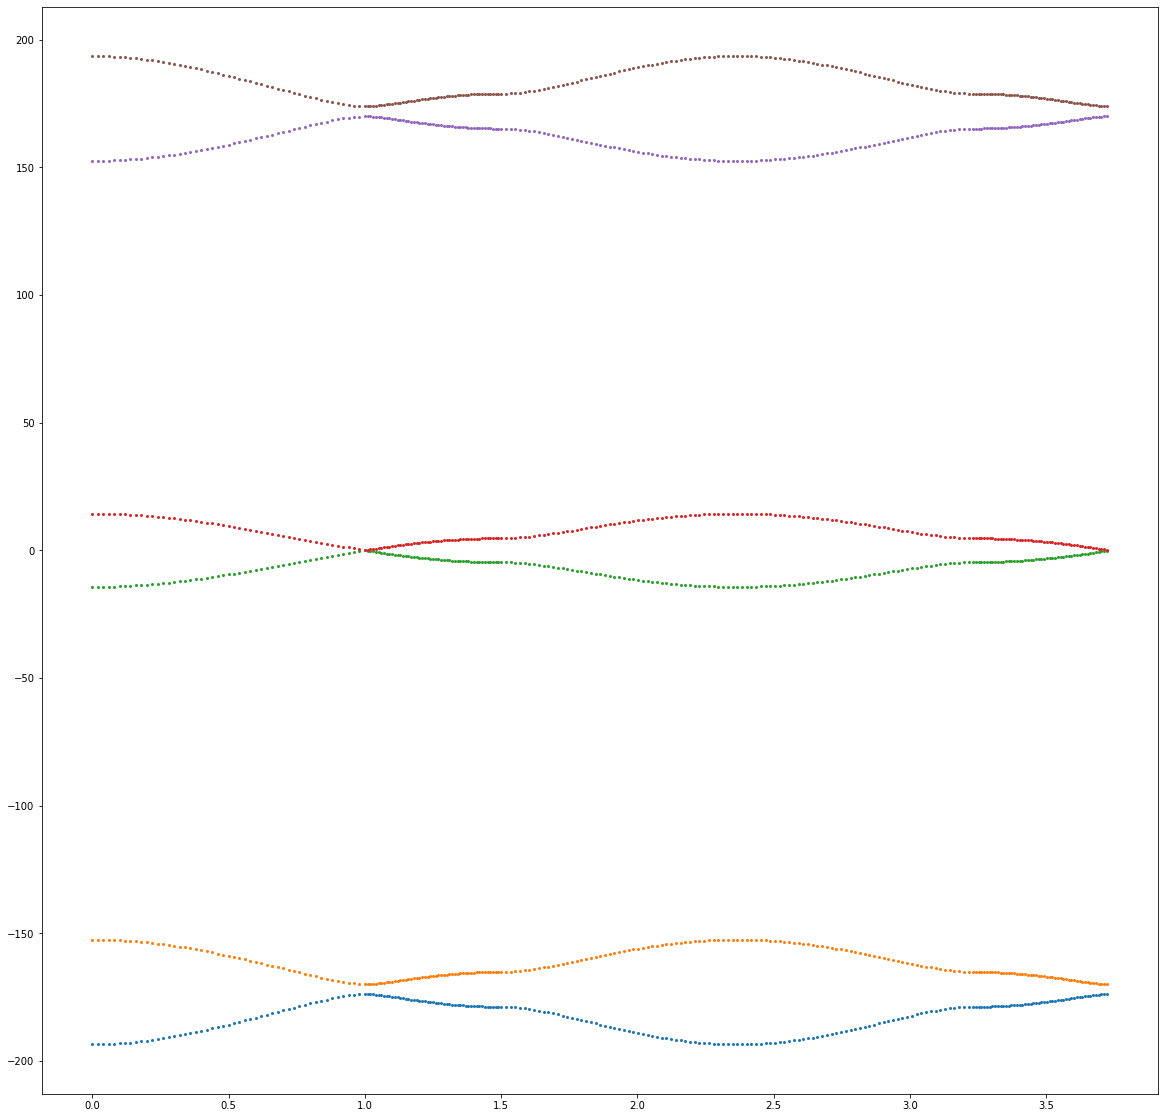

In [8]:
plt.figure(figsize=(20,20))
arrayOfEigenvals=np.array(listOfEigenvals)# take the 8 bands closest to 0 energy

for i in range(158,164):
    plt.scatter(len_k, arrayOfEigenvals[:,i],s=4)
    
#plt.savefig('TBG_In_Flux_BS.png')

In [9]:
listOfEigenvalsForBZ = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
listOfPointsForBZ = []
listOfVecsForBZ = []
listOfWilsons = []
k_shift = -np.array([0.0,0.5])
for i1 in range(50):
    w_first = np.zeros((2,322),dtype=complex)
    w_last = np.zeros((322,2),dtype=complex)
    w_list = []
    
    for j1 in range(50):
        k_vec = i1/50.0*b1 + j1/50.0*b2
        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues        
        listOfEigenvalsForBZ.append(eigenvals)  # add to list
        listOfPointsForBZ.append(k_vec)
        listOfVecsForBZ.append(eigenvecs)
        u_matrix = eigenvecs[:,160:162] # flat bands for wilson loop
        if j1 == 0:
            w_last = u_matrix
            w_first = u_matrix.conj().T
        else:
            w_list.append(np.dot(u_matrix,u_matrix.conj().T))
            
    for uDaggeru in w_list: # contract
        w_first = np.dot(w_first,uDaggeru)
        
    listOfWilsons.append(np.dot(w_first,w_last))

In [10]:
arrayOfEigenvaluesForBZ = np.array(listOfEigenvalsForBZ)
arrayOfPointsForBZ = np.array(listOfPointsForBZ)
arrayOfVecsForBZ = np.array(listOfVecsForBZ)

In [11]:
def plotHexagon(points,l1,l2):
    # first, translate the states into the hexagon
    # define the unit vectors that define the hexagon
    dist = np.linalg.norm(l1)
    hex1 = l1/np.linalg.norm(l1)
    hex2 = l2/np.linalg.norm(l2)
    l3 = l2 - l1
    hex3 = l3/np.linalg.norm(l3)
    newPoints = []
    for coords in points:
        len1 = np.dot(coords, hex1)
        len2 = np.dot(coords, hex2)
        len3 = np.dot(coords, hex3)
        if len1 < 0.5*dist+0.00005 and len2 < 0.5*dist+0.00005:
            newPoints.append(coords)
        elif len1 > dist and len2 > dist:
            newPoints.append(coords-l1-l2)
        elif len3 > 0:
            newPoints.append(coords-l2)
        else:
            newPoints.append(coords-l1)
            
    return(np.array(newPoints))

In [12]:
newCoords = plotHexagon(arrayOfPointsForBZ,b1,b2)

/home/aaron/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


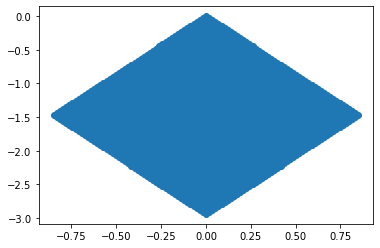

In [13]:
plt.scatter(arrayOfPointsForBZ[:,0],arrayOfPointsForBZ[:,1])

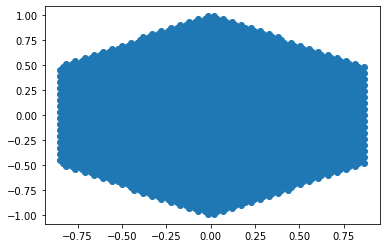

In [14]:
plt.scatter(newCoords[:,0],newCoords[:,1])

In [15]:
def inHexagon(pointsx,pointsy,l1,l2):
    # first, translate the states into the hexagon
    # define the unit vectors that define the hexagon
    matrixOfVals = np.zeros(np.shape(pointsx))
    dist = np.linalg.norm(l1)
    hex1 = l1/np.linalg.norm(l1)
    hex2 = l2/np.linalg.norm(l2)
    l3 = l2 - l1
    hex3 = l3/np.linalg.norm(l3)
    inside = []
    for i in range(len(pointsx)):
        for j in range(len(pointsx[0])):
            matrixOfVals[i][j] = 0
            coords = np.array([pointsx[i][j],pointsy[i][j]])
            len1 = np.dot(coords, hex1)
            len2 = np.dot(coords, hex2)
            len3 = np.dot(coords, hex3)
            if len1 < np.sqrt(3)/2 and len1 > -np.sqrt(3)/2:
                if len2 < np.sqrt(3)/2 and len2 > -np.sqrt(3)/2:
                    if len3 < np.sqrt(3)/2 and len3 > -np.sqrt(3)/2:
                        matrixOfVals[i][j] = 1.0
    return(matrixOfVals)

/home/aaron/.local/lib/python3.8/site-packages/scipy/interpolate/ndgriddata.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  xi = _ndim_coords_from_arrays(args, ndim=self.points.shape[1])
/home/aaron/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/aaron/.local/lib/python3.8/site-packages/matplotlib/transforms.py:2802: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


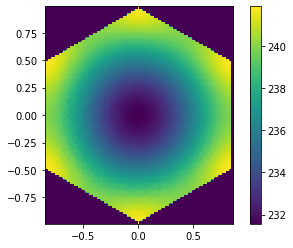

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

newCoords = plotHexagon(np.real(arrayOfPointsForBZ),b1,b2)
x = newCoords[:,0]
y = newCoords[:,1]
z = arrayOfEigenvaluesForBZ[:,164]
pts = np.real(newCoords)
# Set up a regular grid of interpolation points
xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)
# Interpolate
newguess = scipy.interpolate.NearestNDInterpolator(pts,z)
zi = np.multiply(inHexagon(xi,yi,b1,b2),newguess(xi, yi))
plt.imshow(zi, vmin=z.min(), vmax=z.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
#plt.scatter(x, y, c=z)
plt.colorbar()
#plt.savefig('dispersive_3_heatmap.png')

We want to calculate the Wilson loop operator 
$$W(k_1) = \lim_{N \rightarrow \infty} \prod_{j=0}^{N-1} U^\dagger(k_1, \frac{2\pi j}{N}) U(k_1, \frac{2\pi(j+1)}{N}),$$ with the $U$ matrix reading

$$U(k) = (|u_{-M}(k)\rangle,|u_{-M+1}(k)\rangle,| u_{-M+2}(k)\rangle...|u_{M}(k)\rangle ).$$


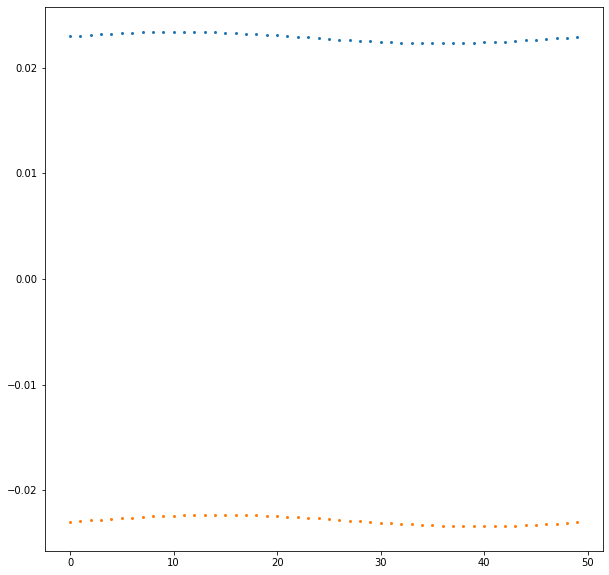

In [17]:
listOfEigvalsWilson = []
for wilsonMatrix in listOfWilsons:
    eigval,eigvec = np.linalg.eig(wilsonMatrix)
    listOfEigvalsWilson.append(-1.0j*np.log(eigval)) # natural log

arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)
plt.figure(figsize=(10,10))

for i in range(2):
    plt.scatter(range(50), arrayOfEigvalsWilson[:,i],s=4)
    
plt.savefig('Wilson_Loop_50_pts_Large_Angle.png')

In [22]:
listOfEigenvalsForBZ = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
listOfPointsForBZ = []
listOfVecsForBZ = []
listOfWilsons = []
k_shift = -np.array([0.0,0.5])
for i1 in range(50):
    w_first = np.zeros((2,322),dtype=complex)
    w_last = np.zeros((322,2),dtype=complex)
    w_list = []
    
    for j1 in range(50):
        k_vec = i1/50.0*b1 + j1/50.0*b2
        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues        
        listOfEigenvalsForBZ.append(eigenvals)  # add to list
        listOfPointsForBZ.append(k_vec)
        listOfVecsForBZ.append(eigenvecs)
        u_matrix = eigenvecs[:,162:164] # flat bands for wilson loop
        if j1 == 0:
            w_last = u_matrix
            w_first = u_matrix.conj().T
        else:
            w_list.append(np.dot(u_matrix,u_matrix.conj().T))
            
    for uDaggeru in w_list: # contract
        w_first = np.dot(w_first,uDaggeru)
        
    listOfWilsons.append(np.dot(w_first,w_last))

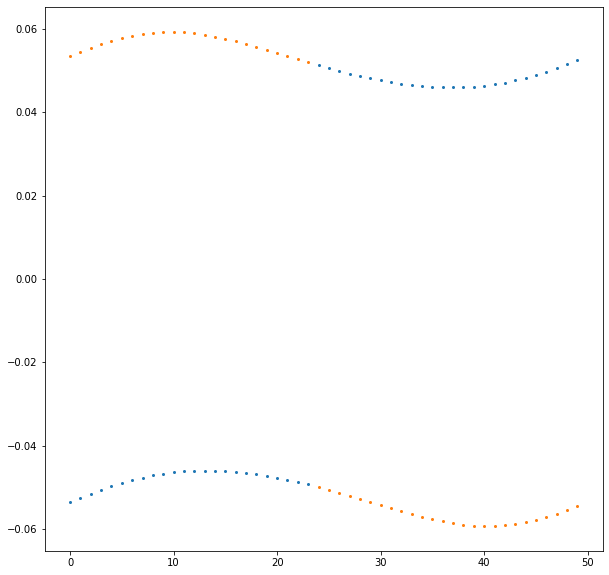

In [23]:
listOfEigvalsWilson = []
for wilsonMatrix in listOfWilsons:
    eigval,eigvec = np.linalg.eig(np.matrix(wilsonMatrix))
    listOfEigvalsWilson.append(-1.0j*np.log(eigval)) # natural log

arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)
plt.figure(figsize=(10,10))

for i in range(2):
    plt.scatter(range(50), arrayOfEigvalsWilson[:,i],s=4)
    
plt.savefig('Wilson_Loop_50_pts_Large_Angle_Dispersive.png')

In [9]:
listOfEigenvalsForBZ = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
listOfPointsForBZ = []
listOfWilsons = []
k_shift = -np.array([0.0,0.5])
for i1 in range(200):
    w_first = np.zeros((2,322),dtype=complex)
    w_last = np.zeros((322,2),dtype=complex)
    
    for j1 in range(200):
        k_vec = i1/200.0*b1 + j1/200.0*b2
        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues        
        listOfEigenvalsForBZ.append(eigenvals)  # add to list
        listOfPointsForBZ.append(k_vec)
        u_matrix = eigenvecs[:,160:162] # flat bands for wilson loop
        if j1 == 0:
            w_last = u_matrix
            w_first = u_matrix.conj().T
        else:
            w_first = np.dot(w_first,np.dot(u_matrix,u_matrix.conj().T))
                    
    listOfWilsons.append(np.dot(w_first,w_last))

In [26]:
#np.save('WilsonHamiltonians200_LL80.npy', np.array(listOfWilsons), allow_pickle=True, fix_imports=True)
#np.save('WilsonEigenvals200_LL80.npy', np.array(listOfEigenvalsForBZ), allow_pickle=True, fix_imports=True)
#np.save('WilsonPoints200_LL80.npy', np.array(listOfPointsForBZ), allow_pickle=True, fix_imports=True)


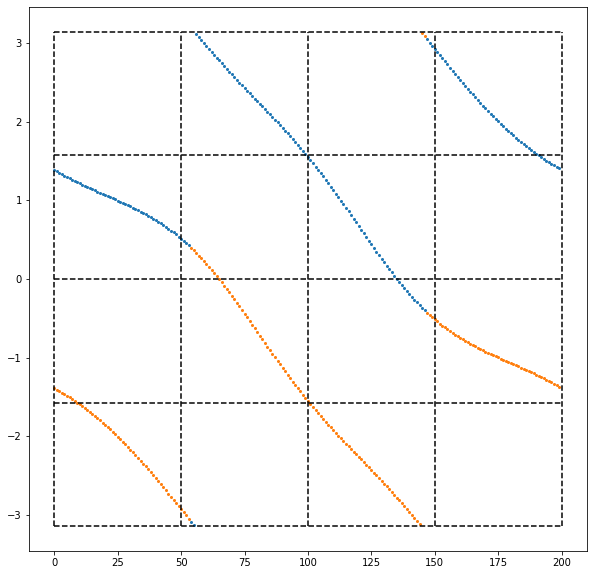

In [23]:
listOfEigvalsWilson = []
for wilsonMatrix in listOfWilsons:
    eigval,eigvec = np.linalg.eig(wilsonMatrix)
    listOfEigvalsWilson.append(-1.0j*np.log(eigval)) # natural log

arrayOfEigvalsWilson = np.array(listOfEigvalsWilson)
plt.figure(figsize=(10,10))

for i in range(2):
    plt.scatter(range(200), arrayOfEigvalsWilson[:,i],s=4)
plt.plot([0.0,200.0],[np.pi,np.pi],'--',c='black')
plt.plot([0.0,200.0],[-np.pi,-np.pi],'--',c='black')
plt.plot([0.0,0.0],[-np.pi,np.pi],'--',c='black')
plt.plot([200.0,200.0],[-np.pi,np.pi],'--',c='black')
plt.plot([0.0,200.0],[np.pi/2,np.pi/2],'--',c='black')
plt.plot([0.0,200.0],[-np.pi/2,-np.pi/2],'--',c='black')
plt.plot([0.0,200.0],[0,0],'--',c='black')
plt.plot([100.0,100.0],[-np.pi,np.pi],'--',c='black')
plt.plot([50.0,50.0],[-np.pi,np.pi],'--',c='black')
plt.plot([150.0,150.0],[-np.pi,np.pi],'--',c='black')
    
plt.savefig('Wilson_Loop_200_pts.png')

In [ ]:
listOfEigenvalsForBZ = []  # will hold all the eigenvalues.  Probably would be faster with sparse matrices and Lanczos
listOfPointsForBZ = []
listOfWilsons = []
k_shift = -np.array([0.0,0.5])
for i1 in range(200):
    w_first = np.zeros((2,322),dtype=complex)
    w_last = np.zeros((322,2),dtype=complex)
    
    for j1 in range(200):
        k_vec = i1/200.0*b1 + j1/200.0*b2
        ham = generateHam(k_vec)  # build Hk
        eigenvals, eigenvecs = np.linalg.eigh(ham)  # find eigenvalues        
        listOfEigenvalsForBZ.append(eigenvals)  # add to list
        listOfPointsForBZ.append(k_vec)
        u_matrix = eigenvecs[:,160:162] # flat bands for wilson loop
        if j1 == 0:
            w_last = u_matrix
            w_first = u_matrix.conj().T
        else:
            w_first = np.dot(w_first,np.dot(u_matrix,u_matrix.conj().T))
                    
    listOfWilsons.append(np.dot(w_first,w_last))